In [1]:
import neutromeratio
from neutromeratio.constants import kT
from simtk import unit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import pickle
from collections import defaultdict
from neutromeratio.analysis import bootstrap_rmse_r

[__init__.py:17 - <module>()] Enabling RDKit 2021.03.3 jupyter extensions
[utils.py:157 - _init_num_threads()] NumExpr defaulting to 8 threads.


In [2]:
# defining the plotting function

def plot_correlation_analysis(
    names: list,
    x_: list,
    y_: list,
    title: str,
    x_label: str,
    y_label: str,
    fontsize: int = 15,
    nsamples: int = 5000,
    yerror: list = [],
    mark_point_by_name=[],
):
    """Plot correlation between x and y.

    Parameters
    ----------
    df : pd.Dataframe
        the df contains columns with colum names 'names', 'x', 'y', 'y-error'
    title : str
        to put above plot. use '' (empty string) for no title.
    nsamples : int
        number of samples to draw for bootstrap
    """

    plt.figure(figsize=[8, 8], dpi=300)
    ax = plt.gca()
    ax.set_title(title, fontsize=fontsize)

    rmse, mae, r = bootstrap_rmse_r(np.array(x_), np.array(y_), 1000)

    plt.text(-9.0, 20.0, r"""MAE$ = {}$ kcal/mol
RMSE$ = {}$ kcal/mol
tautomer pairs$ = {}$""".format(mae,rmse, len(names)), fontsize=fontsize-4, bbox={'facecolor': 'grey', 'alpha': 0.7, 'pad': 5})

    if yerror:
        for X, Y, name, error in zip(x_, y_, names, yerror):
            ax.errorbar(
                X,
                Y,
                yerr=error,
                mfc="blue",
                mec="blue",
                ms=4,
                fmt="o",
                capthick=2,
                capsize=2,
                alpha=0.6,
                ecolor="red",
            )

    else:
        for X, Y, name in zip(x_, y_, names):
            if name in mark_point_by_name:
                ax.scatter(X, Y, color="red", s=13, alpha=0.6)
            else:
                ax.scatter(X, Y, color="blue", s=13, alpha=0.6)

    # draw lines +- 1kcal/mol
    ax.plot((-10.0, 30.0), (-10.0, 30.0), "k--", zorder=-1, linewidth=1.0, alpha=0.5)
    ax.plot((-9.0, 30.0), (-10.0, 29.0), "gray", zorder=-1, linewidth=1.0, alpha=0.5)
    ax.plot((-10.0, 29.0), (-9.0, 30.0), "gray", zorder=-1, linewidth=1.0, alpha=0.5)

    ax.plot((-10.0, 30.0), (0.0, 0.0), "r--", zorder=-1, linewidth=1.0, alpha=0.5)
    ax.plot((0.0, 0.0), (-10.0, 30.0), "r--", zorder=-1, linewidth=1.0, alpha=0.5)

    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    plt.tight_layout()
    plt.fill(
        0.0,
    )
    plt.subplots_adjust(bottom=0.3),  # left=1.3, right=0.3)
    # make sure that we plot a square
    ax.set_aspect("equal", "box")
    # color quadrants
    x = np.arange(0.01, 30, 0.1)
    y = -30  # np.arange(0.01,30,0.1)
    plt.fill_between(x, y, color="#539ecd", alpha=0.2)

    x = -np.arange(0.01, 30, 0.1)
    y = 30  # np.arange(0.01,30,0.1)

    plt.fill_between(x, y, color="#539ecd", alpha=0.2)
    plt.axvspan(-10, 0, color="grey")
    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.setp(ax.get_yticklabels(), fontsize=20)

    ax.set_xlim([-10, 30])
    ax.set_ylim([-10, 30])
    return plt.gca()


In [3]:
# load the experimental and RAFE results
exp_results = pickle.load(open(f'../data/input/exp_results.pickle', 'rb'))
# which potential
potential = 'ANI2x' # or 'ANI1ccx'
csv_file = f'../calculated/Alchemical{potential}_kT.csv'
results = defaultdict(list)
error = defaultdict(list)
exp = defaultdict(list)
with open(csv_file, 'r') as f:
    for line in f.readlines():
        name, ddG, dddG = (line.split(','))
        results[name] = (float(ddG) *kT).value_in_unit(unit.kilocalorie_per_mole)
        error[name] = (float(dddG) *kT).value_in_unit(unit.kilocalorie_per_mole)
        exp[name]= exp_results[name]['energy [kcal/mol]'].value_in_unit(unit.kilocalorie_per_mole)

[]

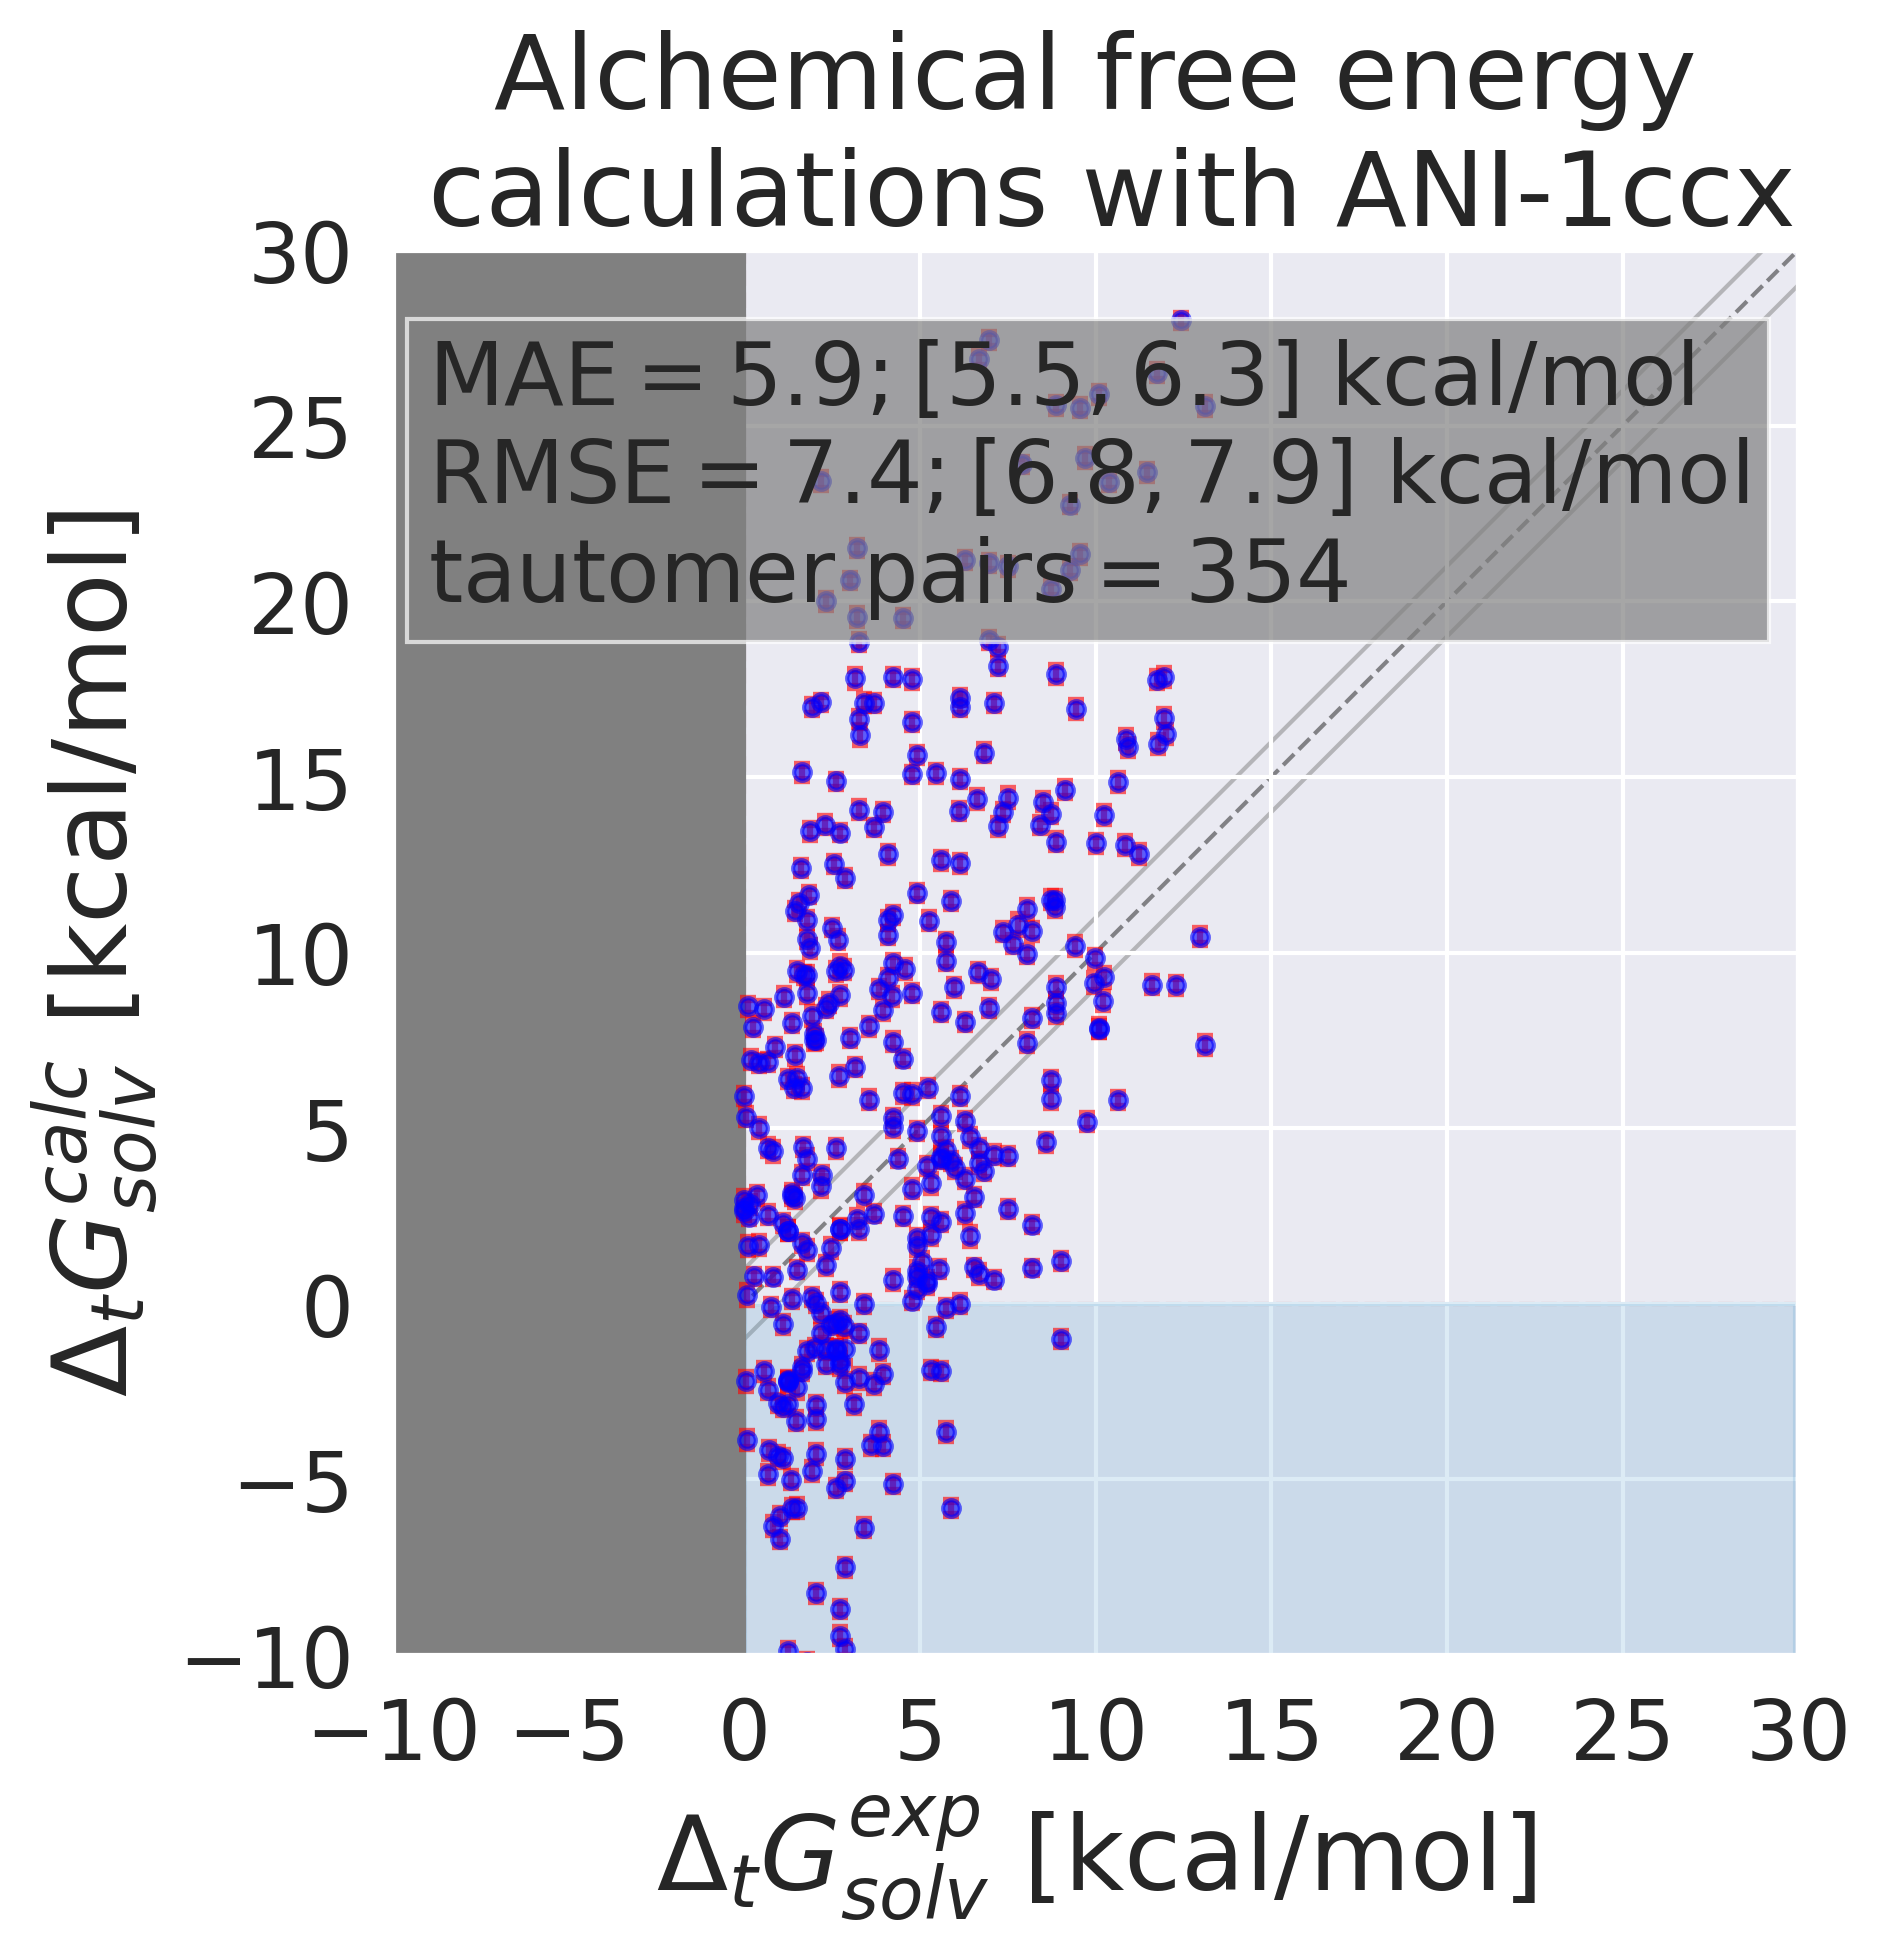

In [4]:
# comparing exp and AFE resutls

import seaborn as sns
sns.set_context('paper')
sns.set(color_codes=True)
x_list = []
y_list = []
yerror_list = []
names = []
for name in exp:
    x, y, y_error = exp[name], results[name], error[name]
    if x < 0.0:
        x *= -1.
        y *= -1.
    
    x_list.append(x)
    y_list.append(y)
    yerror_list.append(y_error)
    names.append(name)
assert(len(x_list) == len(y_list))

f = plot_correlation_analysis(names, x_list, y_list, yerror=yerror_list, title='Alchemical free energy\n calculations with ANI-1ccx', x_label='$\Delta_{t} G_{solv}^{exp}$ [kcal/mol]', y_label='$\Delta_{t} G_{solv}^{calc}$ [kcal/mol]', fontsize=25)
f.plot()